# Anomaly detection

We'll work with the online shoppers purchase intention dataset located in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset)

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

We'll see that customers that made a purchase are a minority. We will treat them as an anomaly, and train an unsupervised model for this demo.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score as ba
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

from feature_engine.selection import SmartCorrelatedSelection

import lime
from lime.lime_tabular import LimeTabularExplainer

## Prepare data

In [2]:
df = pd.read_csv("../online_shoppers_tree.csv")

print(df.shape)

df.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,0,0,-1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,0,0,-1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,0,0,-1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,0,0,-1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,0,1,-1


In [3]:
# This variable is binary and indicates if a customer
# has made a purchase or not

df["Revenue"].value_counts(normalize=True)

Revenue
-1    0.845255
 1    0.154745
Name: proportion, dtype: float64

The people who purchase is not, strictly speaking an anomaly, it's still 15% of the customers, but for the demo, we'll treat them as an anomaly.

In [4]:
# split data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("Revenue", axis=1), 
    df["Revenue"], 
    test_size=0.3, 
    random_state=50,
)

X_train.shape, X_test.shape

((8631, 17), (3699, 17))

## Correlation

Let's find and remove correlated features first.

We know from the previous notebook that there are a few.

In [5]:
# Find correlated features.

sel = SmartCorrelatedSelection(
    threshold=0.7,
    selection_method='variance',
)

sel.fit(X_train, y_train)

# correlated variables
sel.correlated_feature_sets_

[{'ProductRelated', 'ProductRelated_Duration'}, {'BounceRates', 'ExitRates'}]

There are 2 pair of correlated features. Let's plot them against each other.

In [6]:
# Retain variable with highest variability from
# each pair.

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape

((8631, 15), (3699, 15))

## Anomaly detection with One Class SVM

Let's fit a One Class Support Vector Machine, using grid search to find the best configuration.

In [37]:
class OCSVM(OneClassSVM):
    
    def predict_proba():
        
        y = np.array([
            0 - self.predict(),
            self.predict(),
        ])
        
        return y

In [38]:
# set up the one class SVM classifier
ocsvm = OCSVM(
    kernel="poly",
    gamma='auto',
    nu=0.5,
)

# train and evaluate
ocsvm.fit(X_train, y_train)

OCSVM(gamma='auto', kernel='poly')

In [39]:
print(classification_report(y_test, ocsvm.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.91      0.53      0.67      3127
           1       0.22      0.72      0.34       572

    accuracy                           0.56      3699
   macro avg       0.56      0.62      0.50      3699
weighted avg       0.80      0.56      0.62      3699



In [40]:
print(f"Balanced-accuracy in train set: {ba(y_train, ocsvm.predict(X_train))}")
print(f"Balanced-accuracy in test set: {ba(y_test, ocsvm.predict(X_test))}")

Balanced-accuracy in train set: 0.6342001227155012
Balanced-accuracy in test set: 0.6240668908961202


The model is not amazing, but is better than the baseline at least.

Explaining a mediocre model is only going to provide mediocre insights, that is something to keep in mind.

## Lime 

We saw how to explain this model globally in the section on surrogates. Here, we'll explore how to explain them locally with LIME,

In [41]:
explainer = LimeTabularExplainer(
    X_train, 
    ocsvm.feature_names_in_, 
    class_names=["no purchase", "purchase"], 
    discretize_continuous=False,
)

In [35]:
# target

y_test[0]

-1

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
1454,0,0.000000,0,0.0,1225.500000,0.044444,0.0,0.0,3,1,2,9,1,0,0
11029,4,47.833333,0,0.0,2499.990079,0.007608,0.0,0.0,11,2,2,8,2,1,0
10949,2,29.750000,0,0.0,1410.428571,0.026087,0.0,0.0,11,2,2,1,8,0,1
8465,0,0.000000,0,0.0,4293.400000,0.064706,0.0,0.0,11,2,2,3,1,0,0
11180,3,49.125000,0,0.0,344.345238,0.015789,0.0,0.0,11,3,2,1,13,0,0


In [25]:
X_test.iloc[0].to_frame().T

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated_Duration,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
1454,0.0,0.0,0.0,0.0,1225.5,0.044444,0.0,0.0,3.0,1.0,2.0,9.0,1.0,0.0,0.0


In [42]:
exp = explainer.explain_instance(
    X_test.iloc[0].to_frame().T, 
    ocsvm.predict, 
    num_features=3, 
    top_labels=1,
)

C:\Users\Sole\Documents\Repositories\envs\fsml\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OCSVM was fitted with feature names
  warnings.warn(


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

The model makes the wrong prediction.

We could analyze this further to understand why this happened for this particular observation. That would probably make sense in a real world scenario. With this simple dataset we won't get much in return.

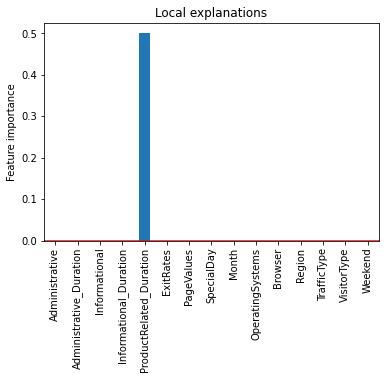

In [36]:
# contributions towards being allocated to no purchase

c = contributions[0][:,1]

pd.Series(c, index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

In [37]:
# let's find an instance of no purchase in the target

y_test.reset_index(drop=True, inplace=True)
y_test[y_test<0]

0      -1
1      -1
2      -1
3      -1
4      -1
       ..
3692   -1
3693   -1
3694   -1
3696   -1
3697   -1
Name: Revenue, Length: 3127, dtype: int64

In [38]:
# This prediction is correct

prediction[4]

array([0.99602339, 0.00397661])

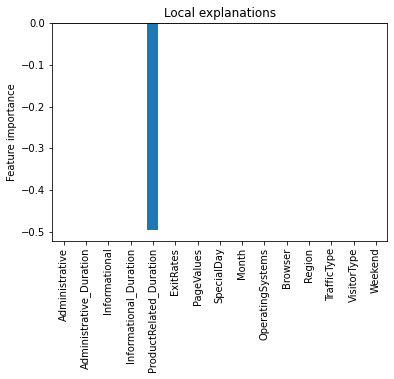

In [39]:
# contributions towards predicting purchase

c = contributions[4][:,1]

pd.Series(c, index=X_train.columns).plot.bar()
plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Feature importance")
plt.title("Local explanations")
plt.show()

This is as much as we can do for local explanations with what we covered in the course so far.

In the next section, we will see LIME and SHAP, to explain black boxes locally.

As a homework, you could train a gradient boosting machine, it works much better than the one class svm and compare the insights derived from interpreting the outputs of that model with those of this model.